In \[6\]:

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn import preprocessing
    from sklearn.preprocessing import StandardScaler, normalize
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.decomposition import PCA

In \[7\]:

    '''
    soft ruffling - 0
    ruffling squeak - 1
    ruffling clock - 2
    ruffling clank - 3
    ruffling squeak clank - 4
    squeak startup - 5
    squeak - 6
    startup - 7
    white noise - 8
    silent - 9
    '''
    standard_labels = ['soft ruffling','ruffling squeak', 'ruffling clock','ruffling clank','ruffling squeak clank', 
         'squeak startup','squeak','startup','white noise','silent']
    classes = range(10)
    map_dict = dict(zip(standard_labels, classes))

In \[8\]:

    df1 = pd.read_csv('Feature_label_acoustic_data_test.csv')
    df2 = pd.read_csv('Feature_label_acoustic_data_train.csv')
    train = pd.concat([df1,df2], ignore_index=True)
    train['HJ_mapped_label'] = train['HJ'].map(map_dict)
    X_train = train.iloc[:, :-7]
    y_train = train['HJ_mapped_label']
    X_train = X_train.loc[:, (X_train != 0).any(axis=0)]

In \[9\]:

    test = pd.read_csv('unseen_data_feature_label.csv')
    test.drop(['filenames', 'AshwinK', 'Yuqi', 'Joel', 'Manasi', 'fig', 'label'], inplace = True, axis = 1)
    test['Huifeng Jin_mapped_label'] = test['Huifeng Jin'].map(map_dict)
    test.drop(['Huifeng Jin'], inplace = True, axis = 1)
    X_test = test.drop(['Huifeng Jin_mapped_label'], axis = 1)
    y_test = test['Huifeng Jin_mapped_label']
    X_test = X_test[X_train.columns.tolist()]

In \[10\]:

    X_train = normalize(X_train)
    X_test = normalize(X_test)

    pca = PCA(n_components=50)
    pca.fit(X_train)
    columns = ['%i' % i for i in range(50)]
    X_train = pd.DataFrame(pca.transform(X_train), columns=columns)
    X_test = pd.DataFrame(pca.transform(X_test), columns=columns)

In \[127\]:

    neighbours = np.arange(1,25)
    train_accuracy =np.empty(len(neighbours))
    test_accuracy = np.empty(len(neighbours))

    for i,k in enumerate(neighbours):
        #Setup a knn classifier with k neighbors
        knn=KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        
        #Fit the model
        knn.fit(X_train,y_train.ravel())
        
        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train, y_train.ravel())
        
        #Compute accuracy on the test set
        test_accuracy[i] = knn.score(X_test, y_test.ravel()) 
        
    plt.title('k-NN Varying number of neighbors')
    plt.plot(neighbours, test_accuracy, label='Testing Accuracy')
    plt.plot(neighbours, train_accuracy, label='Training accuracy')
    plt.legend()
    plt.xlabel('Number of neighbors')
    plt.ylabel('Accuracy')
    plt.show()

<img src="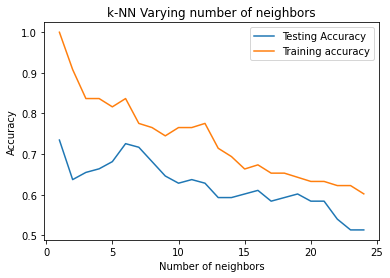%0A" class="jp-needs-light-background" />

In \[128\]:

    idx = np.where(test_accuracy == max(test_accuracy))
    k = neighbours[idx]

    knn=KNeighborsClassifier(n_neighbors=k[0], n_jobs=-1)
    knn.fit(X_train,y_train.ravel())

    knn_predicted_test_labels=knn.predict(X_test)

In \[129\]:

    print(classification_report(y_test,knn_predicted_test_labels, zero_division = 0))

                  precision    recall  f1-score   support

               0       0.42      0.57      0.48        14
               1       1.00      0.33      0.50         3
               2       0.75      0.75      0.75        12
               3       0.00      0.00      0.00         6
               4       0.88      0.88      0.88        17
               5       0.86      0.75      0.80         8
               6       0.20      1.00      0.33         1
               7       0.78      1.00      0.88         7
               8       0.81      0.71      0.76        31
               9       1.00      1.00      1.00        14

        accuracy                           0.73       113
       macro avg       0.67      0.70      0.64       113
    weighted avg       0.75      0.73      0.73       113

In \[93\]:

    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test,y_pred, zero_division = 0))

                  precision    recall  f1-score   support

               0       0.80      0.57      0.67        14
               1       0.00      0.00      0.00         3
               2       0.80      0.67      0.73        12
               3       0.00      0.00      0.00         6
               4       1.00      0.94      0.97        17
               5       0.57      1.00      0.73         8
               6       0.33      1.00      0.50         1
               7       1.00      0.86      0.92         7
               8       0.69      0.87      0.77        31
               9       1.00      1.00      1.00        14

        accuracy                           0.78       113
       macro avg       0.62      0.69      0.63       113
    weighted avg       0.75      0.78      0.75       113

In \[13\]:

    from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
    from hyperopt import tpe

    model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'),
                              algo=tpe.suggest, max_evals=50, trial_timeout=30)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(model.best_model())
    print(classification_report(y_test,y_pred, zero_division = 0))

    100%|█████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.30s/trial, best loss: 0.7]
    100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  3.91s/trial, best loss: 0.6]
    100%|█████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  4.09s/trial, best loss: 0.4]
    100%|█████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  5.76s/trial, best loss: 0.4]
    100%|█████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  5.94s/trial, best loss: 0.4]
    100%|█████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  6.37s/trial, best loss: 0.4]
    100%|█████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  6.19s/trial, best loss: 0.4]
    100%|█████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  6.67s/trial, best loss: 0.4]
    100%|█████████████████████████████████████████████████| 9/9 [00:03<00:00,  3.88s/trial, best loss: 0.30000000000000004]
    100%|███████████████████████████████████████████████| 10/10 [00:04<00:00,  4.19s/trial, best loss: 0.30000000000000004]
    100%|███████████████████████████████████████████████| 11/11 [00:04<00:00,  4.76s/trial, best loss: 0.30000000000000004]
    100%|███████████████████████████████████████████████| 12/12 [00:05<00:00,  5.65s/trial, best loss: 0.30000000000000004]
    100%|███████████████████████████████████████████████| 13/13 [00:05<00:00,  5.29s/trial, best loss: 0.30000000000000004]
    100%|███████████████████████████████████████████████| 14/14 [00:04<00:00,  4.13s/trial, best loss: 0.30000000000000004]
    100%|███████████████████████████████████████████████| 15/15 [00:03<00:00,  3.94s/trial, best loss: 0.30000000000000004]
    100%|██████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  6.31s/trial, best loss: 0.25]
    100%|██████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  5.26s/trial, best loss: 0.25]
    100%|██████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  4.46s/trial, best loss: 0.25]
    100%|██████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.07s/trial, best loss: 0.25]
    100%|██████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  9.02s/trial, best loss: 0.25]
    100%|██████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  3.90s/trial, best loss: 0.25]
    100%|██████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  9.68s/trial, best loss: 0.25]
    100%|██████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  9.52s/trial, best loss: 0.25]
    100%|███████████████████████████████████████████████| 24/24 [00:04<00:00,  4.26s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 25/25 [00:04<00:00,  4.23s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 26/26 [00:04<00:00,  4.32s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 27/27 [00:04<00:00,  4.24s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 28/28 [00:03<00:00,  3.99s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 29/29 [00:03<00:00,  3.95s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 30/30 [00:03<00:00,  3.92s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 31/31 [00:04<00:00,  4.01s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 32/32 [00:04<00:00,  4.04s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 33/33 [00:04<00:00,  4.20s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 34/34 [00:04<00:00,  4.48s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 35/35 [00:04<00:00,  4.23s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 36/36 [00:04<00:00,  4.23s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 37/37 [00:04<00:00,  4.59s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 38/38 [00:04<00:00,  4.07s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 39/39 [00:04<00:00,  4.01s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 40/40 [00:03<00:00,  3.82s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 41/41 [00:04<00:00,  4.09s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 42/42 [00:04<00:00,  4.03s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 43/43 [00:04<00:00,  4.00s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 44/44 [00:04<00:00,  4.06s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 45/45 [00:03<00:00,  3.92s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 46/46 [00:04<00:00,  4.06s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 47/47 [00:03<00:00,  3.95s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 48/48 [00:04<00:00,  4.06s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 49/49 [00:04<00:00,  4.05s/trial, best loss: 0.19999999999999996]
    100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  5.69s/trial, best loss: 0.19999999999999996]

    C:\Users\353983\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
      warnings.warn(

    {'learner': SGDClassifier(alpha=1.2392769781700404e-06, eta0=0.09297578044361661,
                  l1_ratio=3.5388815804095573e-07, learning_rate='adaptive',
                  loss='log', max_iter=765, n_iter_no_change=6, n_jobs=1,
                  penalty='l1', power_t=0.10590502429545257, random_state=0,
                  tol=1.0412277903457324e-05), 'preprocs': (StandardScaler(with_mean=False, with_std=False),), 'ex_preprocs': ()}
                  precision    recall  f1-score   support

               0       0.73      0.79      0.76        14
               1       0.00      0.00      0.00         3
               2       0.78      0.58      0.67        12
               3       0.00      0.00      0.00         6
               4       0.88      0.88      0.88        17
               5       0.86      0.75      0.80         8
               6       0.17      1.00      0.29         1
               7       0.75      0.86      0.80         7
               8       0.80      0.90      0.85        31
               9       0.88      1.00      0.93        14

        accuracy                           0.78       113
       macro avg       0.58      0.68      0.60       113
    weighted avg       0.74      0.78      0.75       113

    C:\Users\353983\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
      warnings.warn(
    C:\Users\353983\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
      warnings.warn(

In \[ \]: